In [1]:
!pip install langchain langgraph langchain-community langchain-text-splitters langchain-groq langchain-huggingface langchain-chroma pymupdf arxiv sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.9/134.9 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import userdata
import os
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
os.environ['HF_TOKEN'] = userdata.get('HF_TOKEN')

In [10]:
from typing import TypedDict, Literal, List
from langchain_core.documents import Document

class AgentState(TypedDict):
    query: str
    clarified_query: str
    needs_clarification: bool
    context: List[Document]
    answer: str
    conversation_history: List[str]
    clarification_count: int

In [4]:
from langchain_groq import ChatGroq
llm = ChatGroq(model_name="openai/gpt-oss-120b", temperature=0)

In [11]:
from langchain_community.document_loaders import ArxivLoader

loader = ArxivLoader(query="retrieval augmented generation", load_max_docs=5)
docs = loader.load()

In [12]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)
splits = text_splitter.split_documents(docs)

In [7]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [13]:
from langchain_chroma import Chroma

vectorstore = Chroma.from_documents(
    documents=splits,
    embedding=embeddings,
    persist_directory="./chroma_db"
)

In [14]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

In [24]:
def analyze_query(state: AgentState) -> AgentState:
    """Analyze if query needs clarification"""
    query = state["query"]

    ambiguous_indicators = [
        len(query.split()) <= 4,  # Short queries
        query.count('?') == 0 and len(query.split()) < 6,  # Statements that might need clarification
        any(word in query.lower() for word in ["what", "how", "why", "when", "where"]) and len(query.split()) <= 5,  # Basic question words with short queries
        any(word in query.lower() for word in ["it", "this", "that", "stuff", "thing"]),  # Pronouns
        any(word in query.lower() for word in ["best", "good", "better", "compare", "vs"])  # Subjective terms
    ]

    needs_clarification = sum(ambiguous_indicators) >= 2 and state["clarification_count"] < 2

    print(f"Query: '{query}'")
    print(f"Ambiguous indicators: {sum(ambiguous_indicators)}")
    print(f"Needs clarification: {needs_clarification}")

    return {
        **state,
        "needs_clarification": needs_clarification
    }

In [25]:
from langchain_core.messages import HumanMessage, AIMessage

def seek_clarification(state: AgentState) -> AgentState:
    """Generate clarification questions"""
    query = state["query"]

    clarification_prompt = f"""
    The user asked: "{query}"

    This query seems ambiguous. Ask 1-2 specific follow-up questions to clarify:
    - What specific aspect they want to know
    - Any constraints or preferences
    - The context or use case

    Be concise and helpful.
    """

    response = llm.invoke([HumanMessage(content=clarification_prompt)])
    clarification_question = response.content

    simulated_clarification = f"I want to understand {query} in the context of machine learning research papers"

    return {
        **state,
        "clarified_query": f"{query} {simulated_clarification}",
        "conversation_history": state["conversation_history"] + [clarification_question, simulated_clarification],
        "clarification_count": state["clarification_count"] + 1
    }

In [26]:
def retrieve_documents(state: AgentState) -> AgentState:
    """Retrieve relevant documents"""
    search_query = state["clarified_query"] if state["clarified_query"] else state["query"]

    docs = retriever.invoke(search_query)

    return {
        **state,
        "context": docs
    }

In [27]:
def generate_answer(state: AgentState) -> AgentState:
    """Generate final answer using retrieved context"""
    context_text = "\n\n".join([doc.page_content for doc in state["context"]])
    query = state["clarified_query"] if state["clarified_query"] else state["query"]

    prompt = f"""
    Based on the conversation history and retrieved context, answer the user's question.

    Original Query: {state["query"]}
    Clarified Query: {query}

    Context:
    {context_text}

    Conversation History:
    {chr(10).join(state["conversation_history"])}

    Provide a comprehensive answer based on the retrieved context.
    """

    response = llm.invoke([HumanMessage(content=prompt)])

    return {
        **state,
        "answer": response.content
    }

In [28]:
def should_clarify(state: AgentState) -> Literal["clarify", "retrieve"]:
    """Conditional edge function"""
    return "clarify" if state["needs_clarification"] else "retrieve"

In [29]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("analyze", analyze_query)
workflow.add_node("clarify", seek_clarification)
workflow.add_node("retrieve", retrieve_documents)
workflow.add_node("generate", generate_answer)

# Add edges
workflow.add_edge(START, "analyze")
workflow.add_conditional_edges("analyze", should_clarify)
workflow.add_edge("clarify", "analyze")  # Loop back after clarification
workflow.add_edge("retrieve", "generate")
workflow.add_edge("generate", END)

app = workflow.compile()

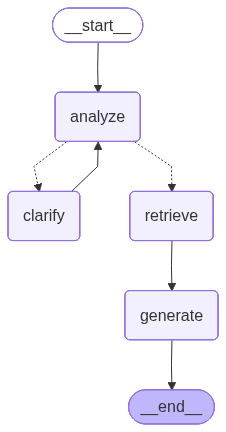

In [30]:
app

In [31]:
# Test with ambiguous query
initial_state = {
    "query": "What is RAG?",
    "clarified_query": "",
    "needs_clarification": False,
    "context": [],
    "answer": "",
    "conversation_history": [],
    "clarification_count": 0
}

result = app.invoke(initial_state)

print("=== CONVERSATION FLOW ===")
for i, msg in enumerate(result["conversation_history"]):
    print(f"{i+1}. {msg}\n")

print("=== FINAL ANSWER ===")
print(result["answer"])

Query: 'What is RAG?'
Ambiguous indicators: 2
Needs clarification: True
Query: 'What is RAG?'
Ambiguous indicators: 2
Needs clarification: True
Query: 'What is RAG?'
Ambiguous indicators: 2
Needs clarification: False
=== CONVERSATION FLOW ===
1. Could you let me know which angle you’re interested in?

1. Are you looking for a high‑level overview of Retrieval‑Augmented Generation, a technical deep‑dive, or how to implement it in a specific framework?  
2. What’s the context—e.g., a research project, a product feature, or just general curiosity?

2. I want to understand What is RAG? in the context of machine learning research papers

3. Could you let me know which angle you’re interested in?

1. Are you looking for a high‑level overview of Retrieval‑Augmented Generation, a technical deep‑dive, or how to implement it in a specific framework?  
2. What’s the context—e.g., a research project, a product you’re building, or just general curiosity?

4. I want to understand What is RAG? in the 

In [32]:
# Test with clear query
clear_state = {
    "query": "How does retrieval augmented generation improve language model performance in question answering tasks?",
    "clarified_query": "",
    "needs_clarification": False,
    "context": [],
    "answer": "",
    "conversation_history": [],
    "clarification_count": 0
}

result_clear = app.invoke(clear_state)

print("=== DIRECT ANSWER (No Clarification Needed) ===")
print(result_clear["answer"])

Query: 'How does retrieval augmented generation improve language model performance in question answering tasks?'
Ambiguous indicators: 0
Needs clarification: False
=== DIRECT ANSWER (No Clarification Needed) ===
**Retrieval‑augmented generation (RAG) – why it helps question‑answering (QA)**  

| What RAG does | Why it matters for QA | How the gain shows up in practice |
|----------------|----------------------|-----------------------------------|
| **1. Pulls in external, task‑specific evidence** – a retriever searches a large corpus (Wikipedia, domain documents, cached hidden‑state indexes, etc.) and returns the few most relevant passages. | QA requires *facts* that are often not stored in the fixed parameters of a language model (LLM). By feeding the model the exact text that contains the answer, the system no longer has to “remember” everything. | The model can answer rare or time‑sensitive questions (e.g., “Who won the 2024 Nobel Prize in Chemistry?”) that would be missing from its